Plot the spectra of each PFT at each site
 - first by site, to compare how different PFT spectra look across sites
 - then combine sites

In [ ]:
fixes to make from Marcos
- Color mean lines by panel or site
- Plot on wavelength rather than band number (use floor/round) - bin to the center of the 5nm window for that band - look at NEONdocumentation to see where that window always is calibrated to
- Create ‘pft comparison across site’ using normalized reflectance values, which is what we use in the RF


In [ ]:
library(neonUtilities)
library(neonOS)
library(geoNEON)
library(dplyr)
library(rhdf5)
library(factoextra) #fviz_nbclust
library(ggplot2)

plot_pfts = function(df, path, all_sites=F) {

    # plot clustering analysis of spectral differences across species
    X_unsc = df %>%
        dplyr::select(-c(shapeID,indvdID,pft,center_X,center_Y,pixelNumber,eastingIDs,northingIDs,site,year))
    X = scale(X_unsc)

    # Kmeans cluster
    # fviz_nbclust(X, kmeans, method = "silhouette")
    km.out = kmeans(X,centers=3)

    # Perform PCA
    pca_result <- prcomp(X, center = TRUE, scale. = TRUE)
    pca_data <- data.frame(pca_result$x, cluster = as.factor(km.out$cluster), pft = df$pft)

    ggplot(pca_data, aes(x = PC1, y = PC2, shape = cluster, color = pft)) +
        geom_point(size = 3) +
        labs(title = "PCA of Hyperspectral Data Clustering",
            x = "Principal Component 1",
            y = "Principal Component 2") +
        theme_minimal() +
        scale_color_brewer(palette = "Set1") +
        theme(legend.position = "bottom")+
        ggtitle( ifelse(unique(df$site)>1, 
                    paste0("All sites",", ",df$year[1]," \n", "PCA"),
                    paste0(df$site[1],", ",df$year[1]," \n", "PCA"))) 
    ggsave(filename = ifelse(all_sites,file.path(path,"cluster_PCA.pdf"),file.path(path,"training/cluster_PCA.pdf")), 
            width = 10, height = 6)

    # calculate mean reflectance per species
    mean_reflectance <- stats::aggregate(X_unsc, by = list(pft = df$pft), FUN = mean) 
    min_reflectance <- stats::aggregate(X_unsc, by = list(pft = df$pft), FUN = min) 
    max_reflectance <- stats::aggregate(X_unsc, by = list(pft = df$pft), FUN = max) 
    sd_reflectance <- stats::aggregate(X_unsc,by = list(pft = df$pft), FUN = sd)
        
    # create a LUT that matches actual wavelength values with the column names,
    # X followed by the rounded wavelength values. 
    wavelength_lut <- data.frame(xwavelength = paste0("w_",1:426), stringsAsFactors = FALSE) %>%
        mutate(wavelength = gsub("^w_", "", xwavelength))
        
    # use the gather function makes wide data longer:
    # https://uc-r.github.io/tidyr 
    # so the reflectance data can easily be grouped by species, 
    # and the mean/min/max reflectance values can be selected for a ribbon plot. 
    mean_refl_tidy <- tidyr::gather(mean_reflectance,
                                    key = xwavelength,
                                    value = "mean_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1]) %>%
        dplyr::left_join(wavelength_lut, by="xwavelength") %>% 
             mutate(wavelength=as.numeric(wavelength),
                    mean_reflectance=ifelse((wavelength >= 192 & wavelength <= 213) | (wavelength >= 282 & wavelength <= 314),NA,mean_reflectance))
    
    # add on the max, min reflectance columns with the same format 
    max_refl_tidy <- tidyr::gather(max_reflectance, key = xwavelength,
                                    value = "max_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1]) 
    
    min_refl_tidy <- tidyr::gather(min_reflectance,key = xwavelength,
                                    value = "min_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1])
    
    sd_refl_tidy <- tidyr::gather(sd_reflectance, key = xwavelength,
                                    value = "sd_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1])

    # combine the mean, min, man reflectance data into one long data frame
    refl_tidy <- mean_refl_tidy %>% 
        left_join(max_refl_tidy %>% select(pft,xwavelength,max_reflectance)) %>%
        left_join(min_refl_tidy %>% select(pft,xwavelength,min_reflectance)) %>%
        left_join(sd_refl_tidy %>% select(pft,xwavelength,sd_reflectance)) %>%
        dplyr::select(-xwavelength) %>%          # remove the Xwavelength values 
        dplyr::select(wavelength, everything())  # reorder to wavelength column is first

    # remove the first reflectance value 
    # refl_tidy <- refl_tidy[refl_tidy$wavelength > 385,] #ais why?

    # add and subtract one standard deviation from the mean 
    refl_tidy$mean_plus_sd <- refl_tidy$mean_reflectance + refl_tidy$sd_reflectance
    refl_tidy$mean_minus_sd <- refl_tidy$mean_reflectance - refl_tidy$sd_reflectance
    # set any negative values to zero for proper plotting 
    refl_tidy$mean_minus_sd[refl_tidy$mean_minus_sd<0] <- 0

    # Calculate the number of data points for each group
    count_data <- df %>% 
        dplyr::count(pft) %>% 
        mutate(label = paste("n =", n))

    # generate the ribbon plot
    options(repr.plot.width=14, repr.plot.width=6)
    ggplot2::ggplot(refl_tidy, 
            aes(x = wavelength, y = mean_reflectance, fill = pft, alpha=0.3)) + 
        geom_ribbon(aes(ymin = mean_minus_sd,ymax = mean_plus_sd,group=pft)) +
        # mean reflectance line
        # placing this after the ribbon shading so the mean curves are visible
        geom_line(linewidth = 0.5, alpha = 1, aes(group=pft) ) + 
        facet_wrap(~ pft) +
        geom_text(data = count_data, aes(x = Inf, y = Inf, label = paste("n =", n)), 
                hjust = 1.1, vjust = 1.3, size = 5, color = "black") +
        guides(alpha=FALSE) + 
        labs(x = "\nWavelength (nm)", y = "Reflectance\n") + 
        ylim(c(0,0.6)) +
        theme_bw() +
        ggtitle(ifelse(all_sites,
                ifelse(unique(df$site)>1,paste0("All sites"," \n", "mean hyperspectral reflectance (+-1 sd)"),
                paste0(df$site[1]," \n", "mean hyperspectral reflectance (+-1 sd)")),
            paste0(df$site[1],", ",df$year[1]," \n", "mean hyperspectral reflectance (+-1 sd)"))) 
    ggsave(filename = ifelse(all_sites,file.path(path,"pft_spectra.pdf"),file.path(path,"training/pft_spectra.pdf")) , 
            width = 10, height = 6)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



### Compare species across sites

In [2]:
sites=c("SJER","SOAP","TEAK")
data_int_path = "/pscratch/sd/a/aspiers/data/intermediate"

sites_all_pixels = data.frame()
for (site in sites){
    site_1_pixels = data.frame()
    site_year_paths = list.dirs(file.path(data_int_path, site), recursive = FALSE)
    for (site_year_path in site_year_paths){

            # Load data
            df_path = file.path(site_year_path,"training/tree_crowns_training-extracted_features_inv.csv")

        if (file.exists(df_path)){
            df = readr::read_csv(df_path)  %>%
                    na.omit()

            # Create new column names starting with "w_" and re-indexing
            x_columns <- grep("^X\\d+", colnames(df), value = TRUE)
            new_names <- paste0("w_", seq_along(x_columns))
            colnames(df)[colnames(df) %in% x_columns] <- new_names

            site_1_pixels    = rbind(site_1_pixels,    df)
            sites_all_pixels = rbind(sites_all_pixels, df)

            # Plot PFT clusters and spectral signatures
            plot_pfts(df, site_year_path)
        } else {
            next
        }
    }
    plot_pfts(site_1_pixels, file.path(data_int_path, site), all_sites=T)
}
plot_pfts(sites_all_pixels, data_int_path, all_sites=T)



Rows: 3329 Columns: 451
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): shapeID, indvdID, pft, site
dbl (447): center_X, center_Y, X384, X389, X394, X399, X404, X409, X414, X41...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pft, xwavelength)`
Joining with `by = join_by(pft, xwavelength)`
Joining with `by = join_by(pft, xwavelength)`
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Rows: 15931 Columns: 451
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): shapeID, indvdID, pft, site
dbl (447): center_X, center_Y, X382, X387, X392, X397, X402, X407, X412, X41...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_

Joining with `by = join_by(pft, site, xwavelength)`
Joining with `by = join_by(pft, site, xwavelength)`
Joining with `by = join_by(pft, site, xwavelength)`


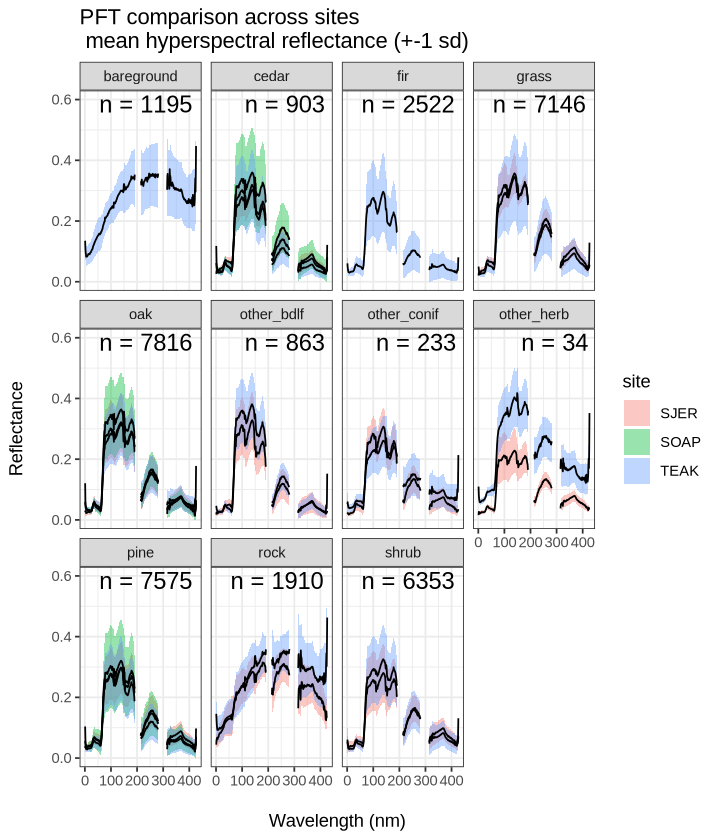

In [29]:
# Plot PFT classes by site


# calculate mean reflectance per PFT per site

X_temp<-sites_all_pixels %>% 
    dplyr::select(-c(shapeID,indvdID,pft,center_X,center_Y,pixelNumber,eastingIDs,northingIDs,site,year))
mean_reflectance <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = mean) 
min_reflectance <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = min) 
max_reflectance <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = max) 
sd_reflectance <- stats::aggregate(X_temp,by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = sd)



# mean_reflectance <- data.frame()
# min_reflectance <- data.frame()
# max_reflectance <- data.frame()
# sd_reflectance <- data.frame()
# for (site in sites) {
#     X_temp<-sites_all_pixels %>% 
#     dplyr::select(-c(shapeID,indvdID,pft,center_X,center_Y,pixelNumber,eastingIDs,northingIDs,site,year))
#     mean_temp <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = mean) 
#     min_temp <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = min) 
#     max_temp <- stats::aggregate(X_temp, by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = max) 
#     sd_temp <- stats::aggregate(X_temp,by = list(pft = sites_all_pixels$pft, site = sites_all_pixels$site), FUN = sd)

#     mean_reflectance = rbind(mean_reflectance,mean_temp)
#     min_reflectance = rbind(min_reflectance,min_temp)
#     max_reflectance = rbind(max_reflectance,max_temp)
#     sd_reflectance = rbind(sd_reflectance,sd_temp)
# }

# create a LUT that matches actual wavelength values with the column names,
# X followed by the rounded wavelength values. 
wavelength_lut <- data.frame(xwavelength = paste0("w_",1:426), stringsAsFactors = FALSE) %>%
    mutate(wavelength = gsub("^w_", "", xwavelength))
    
# use the gather function makes wide data longer:
# https://uc-r.github.io/tidyr 
# so the reflectance data can easily be grouped by PFT, 
# and the mean/min/max reflectance values can be selected for a ribbon plot. 
mean_refl_tidy <- tidyr::gather(mean_reflectance,
                                key = xwavelength,
                                value = "mean_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1]) %>%
    dplyr::left_join(wavelength_lut, by="xwavelength") %>% 
            mutate(wavelength=as.numeric(wavelength),
                mean_reflectance=ifelse((wavelength >= 192 & wavelength <= 213) | (wavelength >= 282 & wavelength <= 314),NA,mean_reflectance))
    
# add on the max, min reflectance columns with the same format 
max_refl_tidy <- tidyr::gather(max_reflectance, key = xwavelength,
                                value = "max_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1]) 

min_refl_tidy <- tidyr::gather(min_reflectance,key = xwavelength,
                                value = "min_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1])

sd_refl_tidy <- tidyr::gather(sd_reflectance, key = xwavelength,
                                value = "sd_reflectance",wavelength_lut$xwavelength[1]:rev(wavelength_lut$xwavelength)[1])

# combine the mean, min, man reflectance data into one long data frame
refl_tidy <- mean_refl_tidy %>% 
    left_join(max_refl_tidy %>% select(pft,site,xwavelength,max_reflectance)) %>%
    left_join(min_refl_tidy %>% select(pft,site,xwavelength,min_reflectance)) %>%
    left_join(sd_refl_tidy %>% select(pft,site,xwavelength,sd_reflectance)) %>%
    dplyr::select(-xwavelength) %>%          # remove the Xwavelength values 
    dplyr::select(wavelength, everything())  # reorder to wavelength column is first

# add and subtract one standard deviation from the mean 
refl_tidy$mean_plus_sd <- refl_tidy$mean_reflectance + refl_tidy$sd_reflectance
refl_tidy$mean_minus_sd <- refl_tidy$mean_reflectance - refl_tidy$sd_reflectance
# set any negative values to zero for proper plotting 
refl_tidy$mean_minus_sd[refl_tidy$mean_minus_sd<0] <- 0

# Calculate the number of data points for each group
count_data <- sites_all_pixels %>% 
    dplyr::count(pft) %>% 
    mutate(label = paste("n =", n))

    # generate the ribbon plot
    options(repr.plot.width=14, repr.plot.width=6)
    ggplot2::ggplot(refl_tidy, 
            aes(x = wavelength, y = mean_reflectance, fill = site)) + 
        geom_ribbon(aes(ymin = mean_minus_sd,ymax = mean_plus_sd, group=site), alpha=0.4) +
        # mean reflectance line
        # placing this after the ribbon shading so the mean curves are visible
        geom_line(linewidth = 0.5, alpha = 1, aes(group=site) ) + 
        facet_wrap(~ pft) +
        geom_text(data = count_data, aes(x = Inf, y = Inf, label = paste("n =", n)), 
                hjust = 1.1, vjust = 1.3, size = 5, color = "black") +
        guides(alpha=FALSE) + 
        labs(x = "\nWavelength (nm)", y = "Reflectance\n") + 
        ylim(c(0,0.6)) +
        theme_bw() +
        ggtitle("PFT comparison across sites \n mean hyperspectral reflectance (+-1 sd)")
    ggsave(filename = file.path(data_int_path,"pft_spectra_site_comp.pdf") , 
            width = 10, height = 6)

add-on: evaluate weinstein et al species prediction accuracy for each tree 